In [1]:
import sys
print(sys.executable)

/Users/sherryshen/anaconda3/envs/graph/bin/python


In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from sklearn.cluster import SpectralClustering
import seaborn as sns
from scipy import stats
from scipy.spatial import distance

## Loading results

In [5]:
OUT_PATH = '/Users/sherryshen/Dropbox/PhD/Results/TBI/'

In [6]:
with open(os.path.join(OUT_PATH, 'df_dist.pkl'), 'rb') as f:
    df, conn_dict, df_dist = pickle.load(f)
with open(os.path.join(OUT_PATH, 'df_dist_nonnorm.pkl'), 'rb') as f:
    _, _, df_dist2 = pickle.load(f)

In [7]:
df

,DX_Group,Times
Subject,,
p051,p,"[s1, s2, s3]"
c006,c,[s1]
c032,c,[s1]
p012,p,"[s1, s2, s3]"
c007,c,[s1]
...,...,...
p003,p,"[s1, s2]"
p050,p,"[s1, s2]"
c005,c,[s1]


In [8]:
df_dist

,dx_groups,times,graphedit
0,cp,s1s1,17366250.0
1,cp,s1s2,17479290.0
2,cp,s1s3,17526980.0
3,cp,s1s1,17607028.0
4,cp,s1s2,18005738.0
...,...,...,...
10726,p,s1s3,12503238.0
10727,p,s2s3,12609770.0
10728,p,s1s2,12817878.0
10729,p,s1s2,13638168.0


## Inter-subject analysis:

### test 1: use the first time series

#### Compute:

In [17]:
tests = ['mean(pc)', 'mean(pp)', 'mean(cc)',
         'std(pc)', 'std(pp)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(pp)', 'Normality_stats(cc)',
         'Normality_p(pc)', 'Normality_p(pp)', 'Normality_p(cc)',
         'levene_stats(pc/pp)', 'levene_stats(pc/cc)', 'levene_stats(pp/cc)',
         'levene(pc/pp)', 'levene(pc/cc)', 'levene(pp/cc)',
         't-test_stats(pc/pp)', 't-test_stats(pc/cc)', 't-test_stats(pp/cc)',
         't-test_p(pc/pp)', 't-test_p(pc/cc)', 't-test_p(pp/cc)',
         't-test_es(pc/pp)', 't-test_es(pc/cc)', 't-test_es(pp/cc)',
         'mannwhitneyu_stats(pc/pp)', 'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_stats(pp/cc)',
         'mannwhitneyu_p(pc/pp)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_p(pp/cc)',
         'mannwhitneyu_es(pc/pp)', 'mannwhitneyu_es(pc/cc)', 'mannwhitneyu_es(pp/cc)',
         'ANOVA_stats', 'ANOVA_p']
df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's1s1')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cc') & (df_dist['times'] == 's1s1')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

dist_measures = ['euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist2[dist_measure] = df_dist2[dist_measure]/df_dist2[dist_measure].max()
    g0 = df_dist2[(df_dist2['dx_groups'] == 'cp') & (df_dist2['times'] == 's1s1')][dist_measure]
    g1 = df_dist2[(df_dist2['dx_groups'] == 'pp') & (df_dist2['times'] == 's1s1')][dist_measure]
    g2 = df_dist2[(df_dist2['dx_groups'] == 'cc') & (df_dist2['times'] == 's1s1')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

#### Results:

In [18]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(pc),8.578779e-01,7.535284e-01,8.558817e-01,6.656137e-01,7.273819e-01
mean(pp),8.721232e-01,7.731475e-01,8.510272e-01,6.844739e-01,7.400862e-01
mean(cc),8.264866e-01,7.154098e-01,8.510193e-01,6.141653e-01,6.930673e-01
std(pc),3.945551e-02,5.650775e-02,4.366495e-02,8.238415e-02,5.807748e-02
std(pp),3.608302e-02,5.641360e-02,4.543589e-02,8.105188e-02,5.464672e-02
std(cc),3.458167e-02,4.700228e-02,3.699761e-02,6.646545e-02,4.648192e-02
Normality_p(pc),8.180193e-01,7.101764e-06,1.138999e-04,4.291990e-07,5.970720e-14
Normality_p(pp),8.555482e-01,5.042764e-05,1.485320e-04,1.764107e-03,2.551868e-08
Normality_p(cc),1.229734e-01,3.482690e-01,4.618594e-02,1.057633e-03,3.133481e-02


#### Plots:

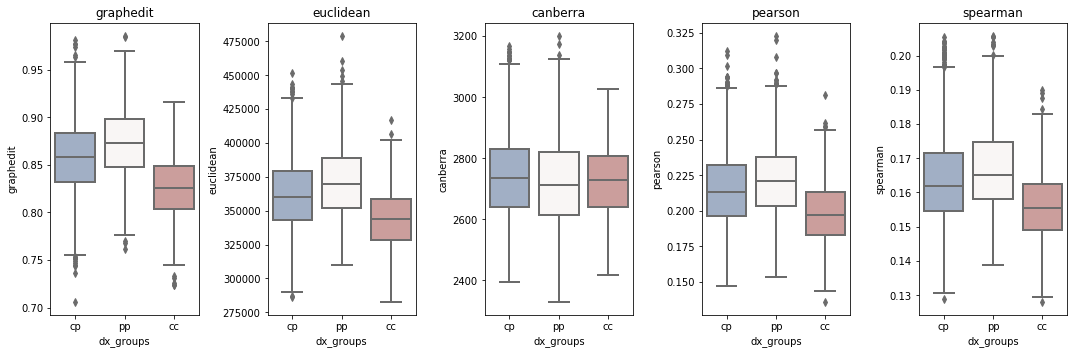

In [45]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p') & (df_dist['times'] == 's1s1')]
df_dist_sub2 = df_dist2[(df_dist2['dx_groups'] != 'p') & (df_dist2['times'] == 's1s1')]
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
params = dict(data=df_dist_sub, x='dx_groups', y='graphedit', order=['cp', 'pp', 'cc'])
sns.boxplot(palette='vlag', linewidth=2, **params)
plt.title('graphedit')

dist_measures2 = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(1, len(dist_measures2)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub2, x='dx_groups', y=dist_measures2[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures2[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 2: use all time series

#### Compute:

In [19]:
tests = ['mean(pc)', 'mean(pp)', 'mean(cc)',
         'std(pc)', 'std(pp)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(pp)', 'Normality_stats(cc)',
         'Normality_p(pc)', 'Normality_p(pp)', 'Normality_p(cc)',
         'levene_stats(pc/pp)', 'levene_stats(pc/cc)', 'levene_stats(pp/cc)',
         'levene(pc/pp)', 'levene(pc/cc)', 'levene(pp/cc)',
         't-test_stats(pc/pp)', 't-test_stats(pc/cc)', 't-test_stats(pp/cc)',
         't-test_p(pc/pp)', 't-test_p(pc/cc)', 't-test_p(pp/cc)',
         't-test_es(pc/pp)', 't-test_es(pc/cc)', 't-test_es(pp/cc)',
         'mannwhitneyu_stats(pc/pp)', 'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_stats(pp/cc)',
         'mannwhitneyu_p(pc/pp)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_p(pp/cc)',
         'mannwhitneyu_es(pc/pp)', 'mannwhitneyu_es(pc/cc)', 'mannwhitneyu_es(pp/cc)',
         'ANOVA_stats', 'ANOVA_p']
df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cc')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

dist_measures = ['euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist2[dist_measure] = df_dist2[dist_measure]/df_dist2[dist_measure].max()
    g0 = df_dist2[(df_dist2['dx_groups'] == 'cp')][dist_measure]
    g1 = df_dist2[(df_dist2['dx_groups'] == 'pp')][dist_measure]
    g2 = df_dist2[(df_dist2['dx_groups'] == 'cc')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

/Users/sherryshen/anaconda3/envs/graph/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Results:

In [20]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(pc),8.609979e-01,7.595095e-01,8.519882e-01,6.699116e-01,7.292145e-01
mean(pp),8.784123e-01,7.850334e-01,8.431747e-01,6.933518e-01,7.455284e-01
mean(cc),8.264866e-01,7.154098e-01,8.510193e-01,6.141653e-01,6.930673e-01
std(pc),4.078144e-02,5.900474e-02,4.049648e-02,8.335262e-02,5.730731e-02
std(pp),3.767868e-02,5.857917e-02,4.260327e-02,8.025016e-02,5.587254e-02
std(cc),3.458167e-02,4.700228e-02,3.699761e-02,6.646545e-02,4.648192e-02
Normality_p(pc),3.935579e-01,5.148315e-11,1.787853e-04,4.911888e-11,2.445573e-26
Normality_p(pp),4.445673e-05,7.722514e-14,5.946670e-05,1.576576e-08,4.023276e-29
Normality_p(cc),1.229734e-01,3.482690e-01,4.618594e-02,1.057633e-03,3.133481e-02


#### Plots:

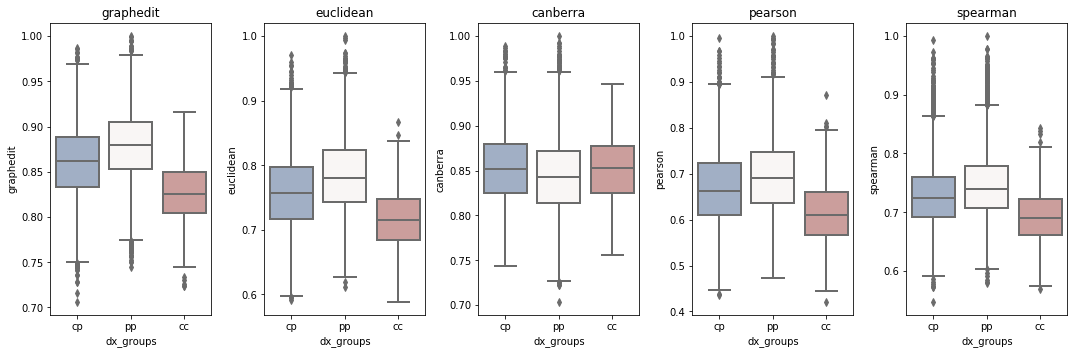

In [21]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p')]
df_dist_sub2 = df_dist2[(df_dist2['dx_groups'] != 'p')]
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
params = dict(data=df_dist_sub, x='dx_groups', y='graphedit', order=['cp', 'pp', 'cc'])
sns.boxplot(palette='vlag', linewidth=2, **params)
plt.title('graphedit')

dist_measures2 = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(1, len(dist_measures2)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub2, x='dx_groups', y=dist_measures2[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures2[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 3: seperate each time series (control vs patient)

#### Compute:

In [29]:
tests = ['mean(s1s1)', 'mean(s1s2)', 'mean(s1s3)',
         'std(s1s1)', 'std(s1s2)', 'std(s1s3)',
         'Normality_stats(s1s1)', 'Normality_stats(s1s2)', 'Normality_stats(s1s3)',
         'Normality_p(s1s1)', 'Normality_p(s1s2)', 'Normality_p(s1s3)',
         'levene_stats(s1s1/s1s2)', 'levene_stats(s1s1/s1s3)', 'levene_stats(s1s2/s1s3)',
         'levene(s1s1/s1s2)', 'levene(s1s1/s1s3)', 'levene(s1s2/s1s3)',
         't-test_stats(s1s1/s1s2)', 't-test_stats(s1s1/s1s3)', 't-test_stats(s1s2/s1s3)',
         't-test_p(s1s1/s1s2)', 't-test_p(s1s1/s1s3)', 't-test_p(s1s2/s1s3)',
         't-test_es(s1s1/s1s2)', 't-test_es(s1s1/s1s3)', 't-test_es(s1s2/s1s3)',
         'mannwhitneyu_stats(s1s1/s1s2)', 'mannwhitneyu_stats(s1s1/s1s3)', 'mannwhitneyu_stats(s1s2/s1s3)',
         'mannwhitneyu_p(s1s1/s1s2)', 'mannwhitneyu_p(s1s1/s1s3)', 'mannwhitneyu_p(s1s2/s1s3)',
         'mannwhitneyu_es(s1s1/s1s2)', 'mannwhitneyu_es(s1s1/s1s3)', 'mannwhitneyu_es(s1s2/s1s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s2')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

dist_measures = ['euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist2[dist_measure] = df_dist2[dist_measure]/df_dist2[dist_measure].max()
    g0 = df_dist2[(df_dist2['dx_groups'] == 'cp') & (df_dist2['times'] == 's1s1')][dist_measure]
    g1 = df_dist2[(df_dist2['dx_groups'] == 'cp') & (df_dist2['times'] == 's1s2')][dist_measure]
    g2 = df_dist2[(df_dist2['dx_groups'] == 'cp') & (df_dist2['times'] == 's1s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

#### Results:

In [30]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(s1s1),0.857878,0.753528,0.855882,6.656137e-01,7.273819e-01
mean(s1s2),0.860623,0.761287,0.849801,6.722821e-01,7.288322e-01
mean(s1s3),0.864916,0.764593,0.849681,6.725019e-01,7.316733e-01
std(s1s1),0.039456,0.056508,0.043665,8.238415e-02,5.807748e-02
std(s1s2),0.039519,0.059469,0.038444,8.199319e-02,5.930879e-02
std(s1s3),0.043085,0.060720,0.038296,8.553235e-02,5.427694e-02
Normality_p(s1s1),0.818019,0.000007,0.000114,4.291990e-07,5.970720e-14
Normality_p(s1s2),0.451806,0.000002,0.000220,1.214596e-06,4.328797e-18
Normality_p(s1s3),0.097733,0.000716,0.000125,8.230723e-03,1.080489e-14


#### Plots:

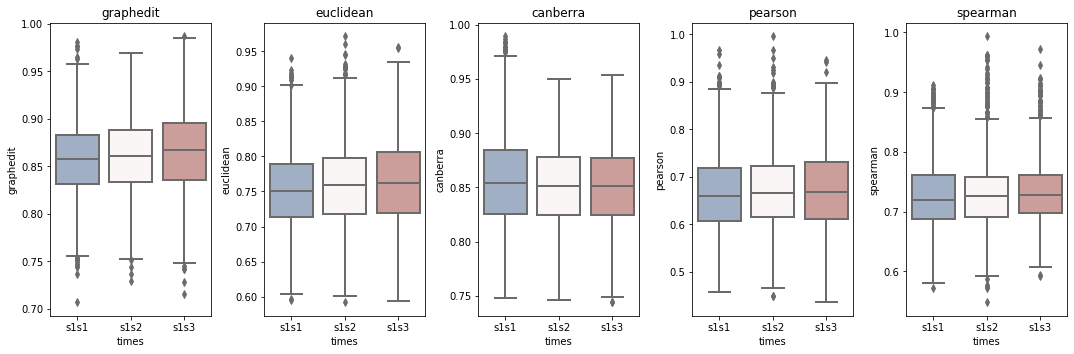

In [31]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'cp')]
df_dist_sub2 = df_dist2[(df_dist2['dx_groups'] == 'cp')]
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
params = dict(data=df_dist_sub, x='times', y='graphedit', order=['s1s1', 's1s2', 's1s3'])
sns.boxplot(palette='vlag', linewidth=2, **params)
plt.title('graphedit')

dist_measures2 = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(1, len(dist_measures2)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub2, x='times', y=dist_measures2[i], order=['s1s1', 's1s2', 's1s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures2[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 4: seperate each time series (patient vs patient)

#### Compute:

In [35]:
tests = ['mean(s1s1)', 'mean(s2s2)', 'mean(s3s3)',
         'std(s1s1)', 'std(s2s2)', 'std(s3s3)',
         'Normality_stats(s1s1)', 'Normality_stats(s2s2)', 'Normality_stats(s3s3)',
         'Normality_p(s1s1)', 'Normality_p(s2s2)', 'Normality_p(s3s3)',
         'levene_stats(s1s1/s2s2)', 'levene_stats(s1s1/s3s3)', 'levene_stats(s2s2/s3s3)',
         'levene(s1s1/s2s2)', 'levene(s1s1/s3s3)', 'levene(s2s2/s3s3)',
         't-test_stats(s1s1/s2s2)', 't-test_stats(s1s1/s3s3)', 't-test_stats(s2s2/s3s3)',
         't-test_p(s1s1/s2s2)', 't-test_p(s1s1/s3s3)', 't-test_p(s2s2/s3s3)',
         't-test_es(s1s1/s2s2)', 't-test_es(s1s1/s3s3)', 't-test_es(s2s2/s3s3)',
         'mannwhitneyu_stats(s1s1/s2s2)', 'mannwhitneyu_stats(s1s1/s3s3)', 'mannwhitneyu_stats(s2s2/s3s3)',
         'mannwhitneyu_p(s1s1/s2s2)', 'mannwhitneyu_p(s1s1/s3s3)', 'mannwhitneyu_p(s2s2/s3s3)',
         'mannwhitneyu_es(s1s1/s2s2)', 'mannwhitneyu_es(s1s1/s3s3)', 'mannwhitneyu_es(s2s2/s3s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's2s2')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's3s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

dist_measures = ['euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist2[dist_measure] = df_dist2[dist_measure]/df_dist2[dist_measure].max()
    g0 = df_dist2[(df_dist2['dx_groups'] == 'pp') & (df_dist2['times'] == 's1s1')][dist_measure]
    g1 = df_dist2[(df_dist2['dx_groups'] == 'pp') & (df_dist2['times'] == 's2s2')][dist_measure]
    g2 = df_dist2[(df_dist2['dx_groups'] == 'pp') & (df_dist2['times'] == 's3s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

#### Results:

In [36]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(s1s1),8.721232e-01,7.731475e-01,8.510272e-01,0.684474,7.400862e-01
mean(s2s2),8.780041e-01,7.891456e-01,8.387387e-01,0.699189,7.455765e-01
mean(s3s3),8.849827e-01,7.930747e-01,8.379302e-01,0.694997,7.509878e-01
std(s1s1),3.608302e-02,5.641360e-02,4.543589e-02,0.081052,5.464672e-02
std(s2s2),3.683072e-02,6.039574e-02,3.946530e-02,0.079805,5.676895e-02
std(s3s3),3.895684e-02,5.797744e-02,4.055692e-02,0.078828,5.553588e-02
Normality_p(s1s1),8.555482e-01,5.042764e-05,1.485320e-04,0.001764,2.551868e-08
Normality_p(s2s2),7.535269e-02,6.332119e-03,2.799833e-01,0.087711,6.425100e-08
Normality_p(s3s3),1.020545e-01,1.143694e-01,7.398007e-03,0.439862,4.355597e-11


#### Plots:

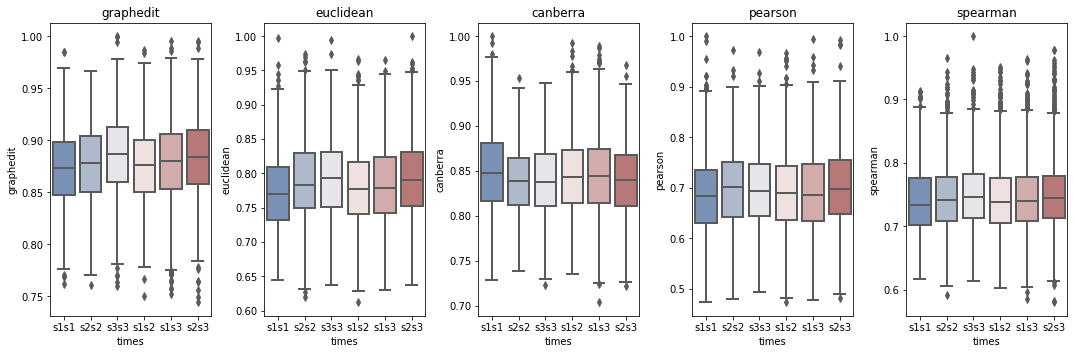

In [37]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'pp')]
df_dist_sub2 = df_dist2[(df_dist2['dx_groups'] == 'pp')]
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
params = dict(data=df_dist_sub, x='times', y='graphedit', order=['s1s1', 's2s2', 's3s3', 's1s2', 's1s3', 's2s3'])
sns.boxplot(palette='vlag', linewidth=2, **params)
plt.title('graphedit')

dist_measures2 = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(1, len(dist_measures2)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub2, x='times', y=dist_measures2[i], order=['s1s1', 's2s2', 's3s3', 's1s2', 's1s3', 's2s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures2[i])

plt.tight_layout(pad=1.0)
plt.show()

## Intra-subject analysis:

### test 5: seperate each time series (single patient)

#### Compute:

In [40]:
tests = ['mean(s1s2)', 'mean(s1s3)', 'mean(s2s3)',
         'std(s1s2)', 'std(s1s3)', 'std(s2s3)',
         'Normality_stats(s1s2)', 'Normality_stats(s1s3)', 'Normality_stats(s2s3)',
         'Normality_p(s1s2)', 'Normality_p(s1s3)', 'Normality_p(s2s3)',
         'levene_stats(s1s2/s1s3)', 'levene_stats(s1s2/s2s3)', 'levene_stats(s1s3/s2s3)',
         'levene(s1s2/s1s3)', 'levene(s1s2/s2s3)', 'levene(s1s3/s2s3)',
         't-test_stats(s1s2/s1s3)', 't-test_stats(s1s2/s2s3)', 't-test_stats(s1s3/s2s3)',
         't-test_p(s1s2/s1s3)', 't-test_p(s1s2/s2s3)', 't-test_p(s1s3/s2s3)',
         't-test_es(s1s2/s1s3)', 't-test_es(s1s2/s2s3)', 't-test_es(s1s3/s2s3)',
         'mannwhitneyu_stats(s1s2/s1s3)', 'mannwhitneyu_stats(s1s2/s2s3)', 'mannwhitneyu_stats(s1s3/s2s3)',
         'mannwhitneyu_p(s1s2/s1s3)', 'mannwhitneyu_p(s1s2/s2s3)', 'mannwhitneyu_p(s1s3/s2s3)',
         'mannwhitneyu_es(s1s2/s1s3)', 'mannwhitneyu_es(s1s2/s2s3)', 'mannwhitneyu_es(s1s3/s2s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's1s2')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's1s3')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's2s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

dist_measures = ['euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist2[dist_measure] = df_dist2[dist_measure]/df_dist2[dist_measure].max()
    g0 = df_dist2[(df_dist2['dx_groups'] == 'p') & (df_dist2['times'] == 's1s2')][dist_measure]
    g1 = df_dist2[(df_dist2['dx_groups'] == 'p') & (df_dist2['times'] == 's1s3')][dist_measure]
    g2 = df_dist2[(df_dist2['dx_groups'] == 'p') & (df_dist2['times'] == 's2s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

#### Results:

In [41]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(s1s2),0.706816,0.625220,0.766930,0.446974,0.588623
mean(s1s3),0.725408,0.638510,0.772033,0.460728,0.606154
mean(s2s3),0.725321,0.633946,0.765841,0.453386,0.604880
std(s1s2),0.048611,0.049147,0.055938,0.078773,0.044554
std(s1s3),0.054644,0.048772,0.055737,0.077182,0.041269
std(s2s3),0.060182,0.055224,0.059382,0.087209,0.045661
Normality_p(s1s2),0.160738,0.405616,0.785466,0.064596,0.852627
Normality_p(s1s3),0.381276,0.600875,0.227009,0.188644,0.569035
Normality_p(s2s3),0.687955,0.601853,0.375965,0.751768,0.307174


#### Plots:

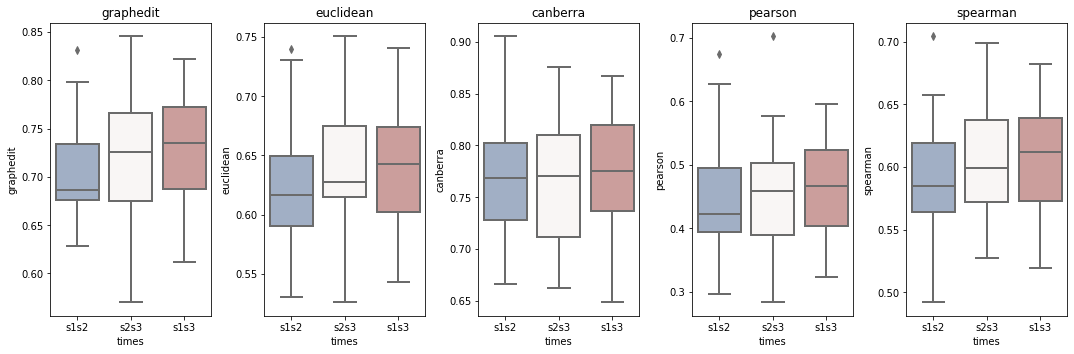

In [43]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'p')]
df_dist_sub2 = df_dist2[(df_dist2['dx_groups'] == 'p')]
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
params = dict(data=df_dist_sub, x='times', y='graphedit', order=['s1s2', 's2s3', 's1s3'])
sns.boxplot(palette='vlag', linewidth=2, **params)
plt.title('graphedit')

dist_measures2 = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(1, len(dist_measures2)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub2, x='times', y=dist_measures2[i], order=['s1s2', 's2s3', 's1s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures2[i])

plt.tight_layout(pad=1.0)
plt.show()